In [1]:
import scipy.io as sio
import numpy as np

# Load the dataset
data_b = sio.loadmat('/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1b.mat')

# Convert the EEG signals to microvolt values
cnt_b = 0.1 * np.double(data_b['cnt'])

# Check the shape of the loaded data for one subject
print(f"Data shape for subject B: {cnt_b.shape}")
print(f"Sampling rate for subject B: {data_b['nfo']['fs'][0][0]}")
print(f"Classes for subject B: {data_b['nfo']['classes'][0]}")


Data shape for subject B: (190594, 59)
Sampling rate for subject B: [[100]]
Classes for subject B: [array([[array(['left'], dtype='<U4'), array(['right'], dtype='<U5')]],
       dtype=object)                                                   ]


In [2]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Parameters for the bandpass filter
lowcut = 8.0
highcut = 15.0
fs = 100  # Sampling rate

# Apply the filter to subject B's data
filtered_cnt_b = bandpass_filter(cnt_b, lowcut, highcut, fs)

# Let's check the shape of the filtered data to ensure it matches the original
print(f"Filtered data shape for subject B: {filtered_cnt_b.shape}")

Filtered data shape for subject B: (190594, 59)


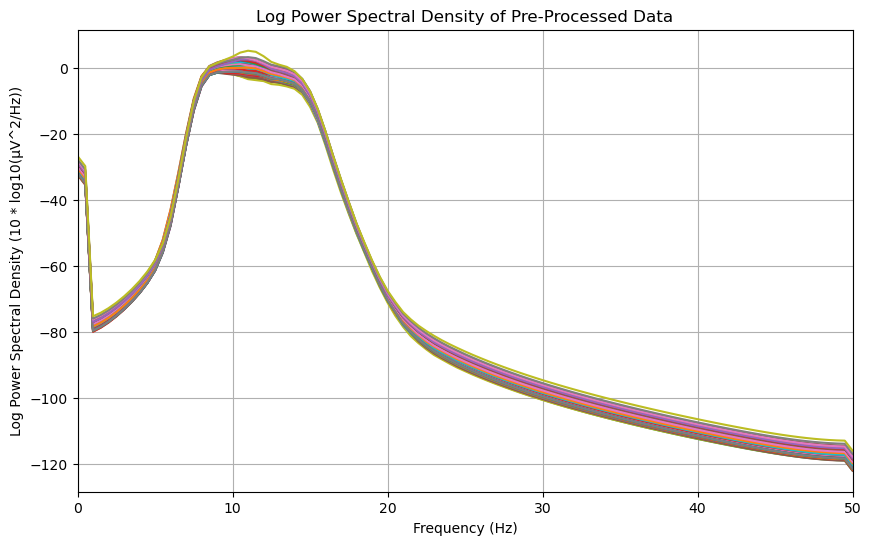

In [3]:
import matplotlib.pyplot as plt
from scipy.signal import welch

# Parameters
nperseg = fs * 2  # Two-second windows

# Compute PSD using Welch's method
frequencies, psd = welch(filtered_cnt_b, fs, nperseg=nperseg, axis=0)

# Convert PSD to log scale (dB)
log_psd = 10 * np.log10(psd)

# Plot the log power spectral density for each channel
plt.figure(figsize=(10, 6))
for i in range(log_psd.shape[1]):  # Iterate over each channel
    plt.plot(frequencies, log_psd[:, i])

plt.title('Log Power Spectral Density of Pre-Processed Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power Spectral Density (10 * log10(μV^2/Hz))')
plt.xlim([0, 50])  
plt.grid(True)
plt.show()


In [4]:
from sklearn.decomposition import FastICA

# Perform ICA
ica = FastICA(n_components=59, random_state=0)
ica_data_b = ica.fit_transform(filtered_cnt_b)  # Reconstruct signals
ica_data_b = ica_data_b @ ica.mixing_.T  # Reapply the mixing matrix

# Check the shape of the ICA-processed data to confirm
print(f"ICA processed data shape for subject B: {ica_data_b.shape}")


ICA processed data shape for subject B: (190594, 59)


/Users/junaeidshoaib/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [5]:
import numpy as np

# Define the time window in terms of samples
fs = 100  # Sampling rate (100 Hz)
start_sample = int(0.5 * fs)  # Start 0.5 seconds after the marker (50 samples)
end_sample = int(2.5 * fs)    # End 2.5 seconds after the marker (250 samples)
epoch_length = end_sample - start_sample  # Length of the time window (200 samples)

# Extract marker positions correctly
marker_positions = data_b['mrk']['pos'][0][0].flatten()  # Flatten to get a 1D array of marker positions

# Print out the first few marker positions to ensure correctness
print(f"First 10 marker positions: {marker_positions[:10]}")

# Determine the number of trials
n_trials = len(marker_positions)

# Preallocate the trials array to hold the segmented data
trials = np.zeros((n_trials, 59, epoch_length))  # 59 channels, 200 samples per trial

# Extract the trials based on the time window relative to each marker position
for i in range(n_trials):
    start_pos = int(marker_positions[i])  # Extract the scalar value from the flattened array
    start_idx = start_pos + start_sample  # Start index for extraction (0.5s after marker)
    end_idx = start_pos + end_sample      # End index for extraction (2.5s after marker)
    
    # Extract and store the trial data
    trials[i] = ica_data_b[start_idx:end_idx, :].T  # Transpose to match (channels, samples)

# Verify the shape of the trials
print(f"Trials shape after time window segmentation: {trials.shape}")

# Print out a few details of the extracted trials
print(f"First trial (shape): {trials[1].shape}")
print(f"First trial (data snippet): {trials[0][:, :5]}")  # Show a snippet of the first 5 samples


# Extract the labels for each trial
labels = data_b['mrk']['y'][0][0].flatten()  # Flatten the array to ensure it's 1D

# Verify the shape and content of the labels
print(f"Labels shape: {labels.shape}")
print(f"First 10 labels: {labels[:10]}")


First 10 marker positions: [2085 2885 3685 4485 5285 6085 6885 7685 8485 9285]
Trials shape after time window segmentation: (200, 59, 200)
First trial (shape): (59, 200)
First trial (data snippet): [[ 1.03703438e+00  1.59327956e+00  1.40572374e+00  8.42979206e-01
   3.53322718e-01]
 [ 6.32283570e-01  1.03986130e+00  1.04297692e+00  7.97529433e-01
   4.91199456e-01]
 [-4.51918774e-01  1.00223490e+00  1.82643673e+00  1.96605368e+00
   1.64316845e+00]
 [ 1.07831055e+00  1.76865216e+00  1.57216896e+00  9.81255085e-01
   5.25300758e-01]
 [ 2.10298418e+00  2.48912842e+00  1.74625206e+00  5.92452194e-01
  -2.42888695e-01]
 [ 2.06598977e+00  2.46106589e+00  1.76066653e+00  6.81314686e-01
  -8.31786259e-02]
 [ 1.83183802e+00  2.22562088e+00  1.56984270e+00  4.62553274e-01
  -4.04599713e-01]
 [ 1.28510912e+00  1.50599092e+00  9.12109093e-01 -4.76786335e-02
  -7.58739028e-01]
 [ 4.84803180e-01  1.37980590e+00  1.37018135e+00  4.84110623e-01
  -6.70745789e-01]
 [-3.28109667e-01  1.05555283e+00  1.

Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 59 dim * 2.4e+15  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating c

Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating c

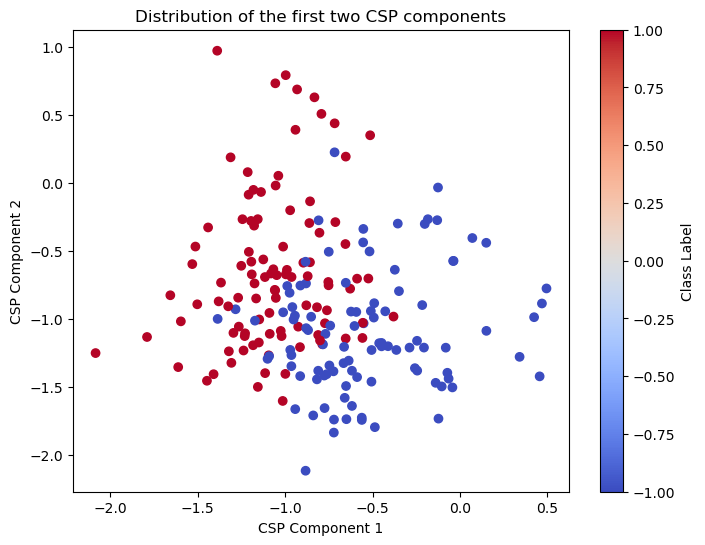

In [6]:
from mne.decoding import CSP
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the CSP object with the number of components
csp = CSP(n_components=6, reg=None, log=True, cov_est='epoch')

# Fit the CSP to the segmented trials and labels
csp.fit(trials, labels)

# Transform the trials using the fitted CSP model
csp_features = csp.transform(trials)

# Verify the shape of the extracted features
print(f"CSP Features shape: {csp_features.shape}")

# Split the CSP features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(csp_features, labels, test_size=0.2, random_state=42)

# Initialize and train a classifier 
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")

# Plot the distribution of the first two CSP components
plt.figure(figsize=(8, 6))
plt.scatter(csp_features[:, 0], csp_features[:, 1], c=labels, cmap='coolwarm')
plt.title('Distribution of the first two CSP components')
plt.xlabel('CSP Component 1')
plt.ylabel('CSP Component 2')
plt.colorbar(label='Class Label')
plt.show()


In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize LDA classifier
lda = LinearDiscriminantAnalysis()

# Train the LDA classifier
lda.fit(X_train, y_train)

# Predict and evaluate
y_pred_lda = lda.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f"LDA Classification Accuracy: {accuracy_lda * 100:.2f}%")


LDA Classification Accuracy: 92.50%


In [8]:
from sklearn.svm import SVC

# Initialize SVM classifier with Gaussian kernel and specified parameters
svm = SVC(kernel='rbf', C=0.06, gamma='scale')

# Train the SVM classifier
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classification Accuracy: {accuracy_svm * 100:.2f}%")


SVM Classification Accuracy: 92.50%


In [9]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Train the Logistic Regression classifier
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Classification Accuracy: {accuracy_log_reg * 100:.2f}%")


Logistic Regression Classification Accuracy: 90.00%


In [10]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree classifier with specified parameters
complex_tree = DecisionTreeClassifier(max_depth=15, criterion='entropy')

# Train the Decision Tree classifier
complex_tree.fit(X_train, y_train)

# Predict and evaluate
y_pred_tree = complex_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Complex Tree Classification Accuracy: {accuracy_tree * 100:.2f}%")


Complex Tree Classification Accuracy: 87.50%


In [11]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
naive_bayes = GaussianNB()

# Train the Naive Bayes classifier
naive_bayes.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = naive_bayes.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Classification Accuracy: {accuracy_nb * 100:.2f}%")


Naive Bayes Classification Accuracy: 92.50%


In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier with specified parameters
knn = KNeighborsClassifier(n_neighbors=100, metric='mahalanobis', metric_params={'VI': np.cov(X_train, rowvar=False)}, weights='distance')

# Train the KNN classifier
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Classification Accuracy: {accuracy_knn * 100:.2f}%")


KNN Classification Accuracy: 85.00%
